In [1]:
import sys
sys.path.append('../NeuroDataResource')

import pickle
import numpy as np
from CollmanAlg import CollmanAlg
from NeuroDataResource import NeuroDataResource
from matplotlib import pyplot as plt

# Overview
The Collman algorithm is essentially a 4 step process:
1.  Break PSD95 channel into xy slices
2. For every xy slice, find the cutoff that makes the media blob size closest to .09 micrometers^2
3. Apply the cutoff to every slice
4. Merge the slices, and run connected components with a thresh of 400nm for final clusters

## Constructor
The constructor for the CollmanAlg takes 2 parameters:
1. A NeuroDataResource containing the channel PSD95_488
2. A pixel resolution in nanometers (i.e. x nanometers/pixel edge)


In [2]:
myToken = pickle.load(open('../NeuroDataResource/data/token.pkl', 'rb'))

ndr = NeuroDataResource('api.boss.neurodata.io',
                        myToken,
                        'collman',
                        'collman15v2',
                        [{'name': 'PSD95_488', 'dtype':'uint8'}])

alg = CollmanAlg(ndr, 1.)

The constructor will throw an error if the resource does not have the correct channels

In [3]:
bad_resource = NeuroDataResource('api.boss.neurodata.io',
                                 myToken,
                                 'collman',
                                 'collman15v2',
                                 [{'name': 'DAPI1st', 'dtype':'uint8'}])

bad_alg = CollmanAlg(bad_resource, 1)

ValueError: PSD95_488 Channel must be in Resource

## Methods
The CollmanAlg class contans 3 methods:
1. get_cluster_median(data): returns the median cluster volume in the data
    - data: labeled data from which to find the median cluster area
    <br/><br/>
2. get_cutoff(data, myMin, myMax, target): recursively binary searches until get_cluster_median is as close to target as possible
    - data: the data to operate on
    - myMin: the min checkable cutoff
    - myMax: the max checkable cutoff
    - target: the target cluster volume median
    - verbose: false by default, will print the binary search
    <br/><br/>
3. detect(zRange, yRange, xRange): pulls data in zRnge, yRange, and xRange from BOSS and runs the full algorithm
    - zRange: range of z values to run alg over
    - yRange: range of y values to run alg over
    - xRange: range of x values to run alg over

### get_cluster_median
Just a couple of simple validation tests

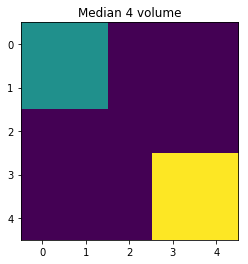

Median:  4.0


In [4]:
synthetic = np.stack([[1, 1, 0, 0, 0],
                      [1, 1, 0, 0, 0],
                      [0, 0, 0, 0, 0],
                      [0, 0, 0, 2, 2],
                      [0, 0, 0, 2, 2]])
plt.title('Median 4 volume')
plt.imshow(synthetic)
plt.show()
print('Median: ', alg.get_cluster_median(synthetic))

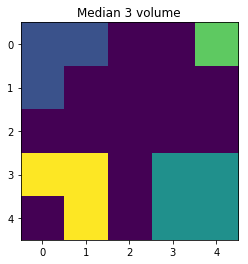

Median:  3.0


In [5]:
synthetic = np.stack([[1, 1, 0, 0, 3],
                      [1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0],
                      [4, 4, 0, 2, 2],
                      [0, 4, 0, 2, 2]])
plt.title('Median 3 volume')
plt.imshow(synthetic)
plt.show()
print('Median: ', alg.get_cluster_median(synthetic))

### get_cutoff
The get_cutoff method runs a binary search for which cutoff gets the cluster median volume closest to the target.

The following test data should find a cutoff between 20 and 21


In [6]:
test = 20 + (synthetic > 0).astype(int)
print(test)

[[21 21 20 20 21]
 [21 20 20 20 20]
 [20 20 20 20 20]
 [21 21 20 21 21]
 [20 21 20 21 21]]


In [7]:
cutoff = alg.get_cutoff(test, 0, 30, 3, verbose=True)
print('Cutoff: ', cutoff)

Med of: 25.0 	at:  15.0
Med of: 0.0 	at:  22.5
Med of: 25.0 	at:  18.75
Med of: 3.0 	at:  20.625
Cutoff:  20.625


## Real Data

In [8]:
alg = CollmanAlg(ndr, 3.)
detections = alg.detect([4, 14], [2000, 3000], [2000, 3000])

In [9]:
data = ndr.get_cutout('PSD95_488', [4, 14], [2000, 3000], [2000, 3000])

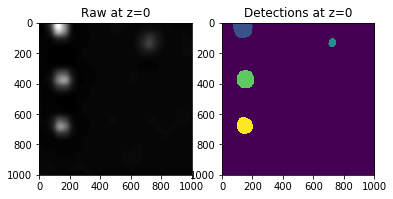

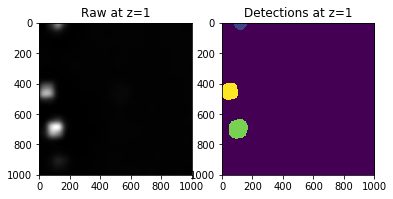

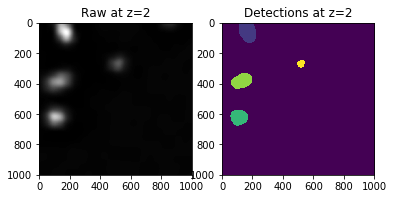

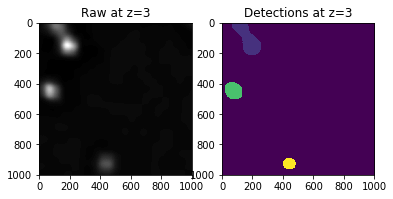

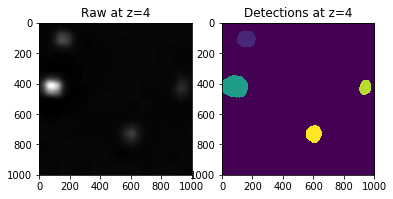

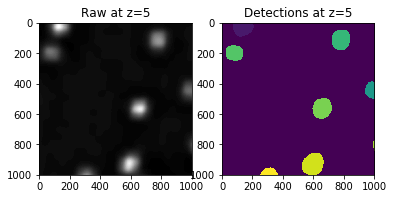

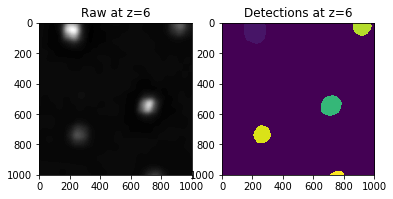

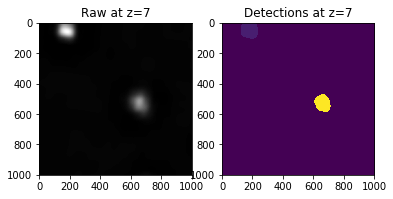

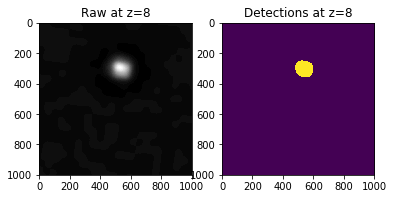

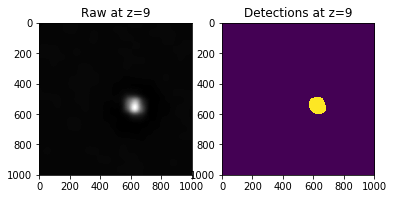

In [16]:
for i in range(10):
    plt.figure()
    plt.subplot(121)
    plt.title('Raw at z=' + str(i))
    plt.imshow(data[i], cmap='gray')
    plt.subplot(122)
    plt.title('Detections at z='+ str(i))
    plt.imshow(detections[i])
    plt.show()